# Init

In [19]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing, visualization
import matplotlib.pyplot as plt

logger = logging.getLogger("beta2")


## Load data 

Data should be in an appropriate format and filtered before when we load it here. It does not have to be scaled. 

In [20]:
feature_type = "CA_inv" # "contacts_5_cutoff" or "CA_inv"
working_dir = os.path.expanduser("~/projects/gpcr/mega/Result_Data/beta2-dror/clustering/{}/".format(feature_type))
raw_data = np.load(working_dir + "samples.npy")
scale_data = True
cluster_indices = np.loadtxt(working_dir + 'cluster_indices_.txt')
data = utils.vectorize(raw_data)  # Our training data to classifiers
labels = utils.create_class_labels(cluster_indices)  #Our training labels to classifiers
feature_to_resids = np.load(
    working_dir + "feature_to_resids.npy")  #Mapping from residue Id to the index of that residue in the data (for proteins with missing residues)
if len(data) != len(labels) or data.shape[1] != len(feature_to_resids):
    raise Exception()
logger.info("Loaded data of shape %s and %s clusters", data.shape, len(set(cluster_indices)))


2018-10-30 16:45:22 beta2-INFO: Loaded data of shape (857, 40186) and 3 clusters


## Define the different methods to use

Every method is encapsulated in a so called FeatureExtractor class which all follow the same interface

In [21]:
n_iterations, n_splits = 6, 4
feature_extractors = [
    fe.MlpFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    fe.ElmFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    fe.KLFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    fe.PCAFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    fe.RandomForestFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


2018-10-30 16:45:23 beta2-INFO: Done. using 5 feature extractors


# Run the relevance analysis

In [22]:
results = []
for extractor in feature_extractors:
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features()
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance))
logger.info("Done")


2018-10-30 16:45:27 beta2-INFO: Computing relevance for extractors MLP
2018-10-30 16:45:31 Extracting feature-DEBUG: Iteration 1 of 24
2018-10-30 16:45:47 Extracting feature-DEBUG: Error: 54.4186046512
2018-10-30 16:45:47 Extracting feature-WARNING: Error too high - not computing feature importance.
2018-10-30 16:45:47 Extracting feature-DEBUG: Iteration 2 of 24
2018-10-30 16:46:07 Extracting feature-DEBUG: Error: 54.2635658915
2018-10-30 16:46:07 Extracting feature-WARNING: Error too high - not computing feature importance.
2018-10-30 16:46:07 Extracting feature-DEBUG: Iteration 3 of 24
2018-10-30 16:46:27 Extracting feature-DEBUG: Error: 55.503875969
2018-10-30 16:46:27 Extracting feature-WARNING: Error too high - not computing feature importance.
2018-10-30 16:46:27 Extracting feature-DEBUG: Iteration 4 of 24
2018-10-30 16:46:45 Extracting feature-DEBUG: Error: 53.9534883721
2018-10-30 16:46:45 Extracting feature-WARNING: Error too high - not computing feature importance.
2018-10-30

2018-10-30 16:54:55 Extracting feature-DEBUG: Iteration 10 of 24
2018-10-30 16:54:56 elm-INFO: Automatically settings number of nodes in first layer to 4000
2018-10-30 16:55:02 Extracting feature-DEBUG: Error: 2.18068535826
2018-10-30 16:55:02 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 16:55:19 Extracting feature-DEBUG: Iteration 11 of 24
2018-10-30 16:55:20 elm-INFO: Automatically settings number of nodes in first layer to 4000
2018-10-30 16:55:27 Extracting feature-DEBUG: Error: 2.49221183801
2018-10-30 16:55:27 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 16:55:44 Extracting feature-DEBUG: Iteration 12 of 24
2018-10-30 16:55:45 elm-INFO: Automatically settings number of nodes in first layer to 4000
2018-10-30 16:55:51 Extracting feature-DEBUG: Error: 1.8691588785
2018-10-30 16:55:51 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 16:56:08 Extracting feature-DEBUG: Iteration 13 of 24


2018-10-30 17:09:11 Extracting feature-DEBUG: Iteration 24 of 24
2018-10-30 17:09:12 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 17:09:34 beta2-INFO: Computing relevance for extractors PCA
2018-10-30 17:09:34 Extracting feature-DEBUG: Iteration 1 of 24
2018-10-30 17:09:34 PCA featurizer-INFO: Training PCA
2018-10-30 17:09:38 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 17:09:38 PCA featurizer-INFO: Selecting 75 components
2018-10-30 17:09:38 Extracting feature-DEBUG: Iteration 2 of 24
2018-10-30 17:09:38 PCA featurizer-INFO: Training PCA
2018-10-30 17:09:42 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 17:09:42 PCA featurizer-INFO: Selecting 75 components
2018-10-30 17:09:42 Extracting feature-DEBUG: Iteration 3 of 24
2018-10-30 17:09:42 PCA featurizer-INFO: Training PCA
2018-10-30 17:09:46 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 17:09:46 PCA feat

2018-10-30 17:11:28 Extracting feature-DEBUG: Iteration 6 of 24
2018-10-30 17:11:29 RF featurizer-INFO: Training RF
2018-10-30 17:11:29 Extracting feature-DEBUG: Error: 8.52713178295
2018-10-30 17:11:29 Extracting feature-WARNING: Error too high - not computing feature importance.
2018-10-30 17:11:29 Extracting feature-DEBUG: Iteration 7 of 24
2018-10-30 17:11:30 RF featurizer-INFO: Training RF
2018-10-30 17:11:31 Extracting feature-DEBUG: Error: 0.934579439252
2018-10-30 17:11:31 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 17:11:31 Extracting feature-DEBUG: Iteration 8 of 24
2018-10-30 17:11:32 RF featurizer-INFO: Training RF
2018-10-30 17:11:32 Extracting feature-DEBUG: Error: 1.09034267913
2018-10-30 17:11:32 Extracting feature-DEBUG: Computing feature importance on all data.
2018-10-30 17:11:32 Extracting feature-DEBUG: Iteration 9 of 24
2018-10-30 17:11:33 RF featurizer-INFO: Training RF
2018-10-30 17:11:34 Extracting feature-DEBUG: Error: 0.9345

# Remap and persist results 

In [23]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance) in results:
    p = postprocessing.PostProcessor(extractor, feature_importance, std_feature_importance, cluster_indices,
                                     working_dir, feature_to_resids=feature_to_resids)
    p.average()
    p.persist()
    postprocessors.append(p)

logger.info("Done")


2018-10-30 18:12:32 postprocessing-DEBUG: Not possible to compute importance per cluster
2018-10-30 18:12:32 postprocessing-DEBUG: Not possible to compute importance per cluster
2018-10-30 18:12:33 beta2-INFO: Done


# Visualize results

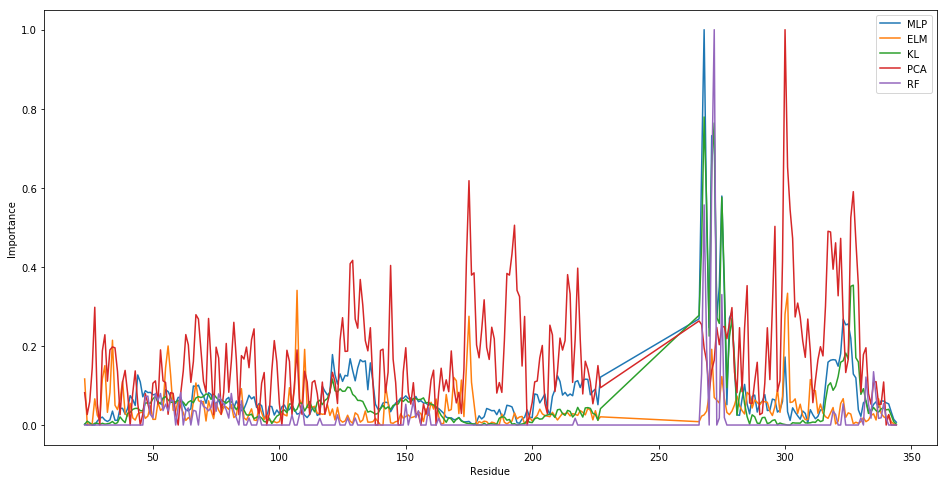

2018-10-30 18:12:38 beta2-INFO: Done


In [24]:
visualization.visualize(postprocessors)
logger.info("Done")